
Basic transfer learning with cats and dogs data

https://github.com/sasidhar-programmer/Tensorflow_Advance_Techniques/blob/main/3-Advance_computer_vision/week%20-1/C3_W1_Lab_1_transfer_learning_cats_dogs.ipynb

In [1]:
import urllib.request
import os
import zipfile
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from shutil import copyfile

In [2]:
# data_url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip"
# data_file_name = "catsdogs.zip"
# download_dir = '../dataset/'
# urllib.request.urlretrieve(data_url, data_file_name)
# zip_ref = zipfile.ZipFile(data_file_name, 'r')
# zip_ref.extractall(download_dir)
# zip_ref.close()

In [3]:


print("Number of cat images:",len(os.listdir('../dataset/PetImages/Cat/')))
print("Number of dog images:", len(os.listdir('../dataset/PetImages/Dog/')))




Number of cat images: 12501
Number of dog images: 12501


In [4]:
# try:
#     os.mkdir('../dataset/cats-v-dogs')
#     os.mkdir('../dataset/cats-v-dogs/training')
#     os.mkdir('../dataset/cats-v-dogs/testing')
#     os.mkdir('../dataset/cats-v-dogs/training/cats')
#     os.mkdir('../dataset/cats-v-dogs/training/dogs')
#     os.mkdir('../dataset/cats-v-dogs/testing/cats')
#     os.mkdir('../dataset/cats-v-dogs/testing/dogs')
# except OSError:
#     pass



In [5]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[:testing_length]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)

In [6]:
CAT_SOURCE_DIR = "../dataset/PetImages/Cat/"
TRAINING_CATS_DIR = "../dataset/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "../dataset/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "../dataset/PetImages/Dog/"
TRAINING_DOGS_DIR = "../dataset/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "../dataset/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# Expected output
# 666.jpg is zero length, so ignoring
# 11702.jpg is zero length, so ignoring

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [7]:
print("Number of training cat images", len(os.listdir('../dataset/cats-v-dogs/training/cats/')))
print("Number of training dog images", len(os.listdir('../dataset/cats-v-dogs/training/dogs/')))
print("Number of testing cat images", len(os.listdir('../dataset/cats-v-dogs/testing/cats/')))
print("Number of testing dog images", len(os.listdir('../dataset/cats-v-dogs/testing/dogs/')))

Number of training cat images 12378
Number of training dog images 12375
Number of testing cat images 2359
Number of testing dog images 2376


In [8]:


TRAINING_DIR = "../dataset/cats-v-dogs/training/"
# Experiment with your own parameters to reach 99.9% validation accuracy or better
train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "../dataset/cats-v-dogs/testing/"

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))



Found 24751 images belonging to 2 classes.
Found 4734 images belonging to 2 classes.


In [9]:

weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_file = "../dataset/inception_v3.h5"
urllib.request.urlretrieve(weights_url, weights_file)

pre_trained_model = InceptionV3(input_shape=(150, 150, 3), include_top=False, weights=None)

pre_trained_model.load_weights(weights_file)

# freeze the layers
for layer in pre_trained_model.layers:
    layer.trainable = False


display(pre_trained_model.summary())

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

None

last layer output shape:  (None, 7, 7, 768)


In [10]:


# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)



In [11]:


# compile the model
model.compile(optimizer=RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['acc'])

# train the model (adjust the number of epochs from 1 to improve performance)
history = model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=2,
            verbose=1)



/home/mo/.local/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/2
  8/248 [..............................] - ETA: 1:44 - loss: 1.1943 - acc: 0.7325

/home/mo/.local/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


248/248 [==============================] - 135s 519ms/step - loss: 0.2218 - acc: 0.9118 - val_loss: 0.0743 - val_acc: 0.9689
Epoch 2/2
248/248 [==============================] - 127s 511ms/step - loss: 0.1461 - acc: 0.9419 - val_loss: 0.0726 - val_acc: 0.9713


<Figure size 432x288 with 0 Axes>

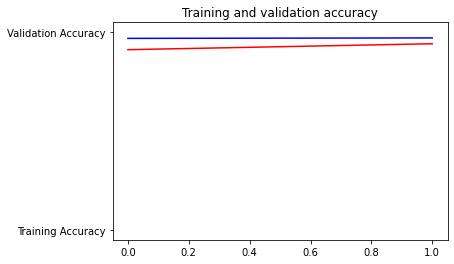

<Figure size 432x288 with 0 Axes>

In [12]:


%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()



In [27]:


import numpy as np
from keras.preprocessing import image


 

path = '../dataset/cats-v-dogs/testing/dogs/97.jpg' 
img = image.load_img(path, target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

image_tensor = np.vstack([x])
classes = model.predict(image_tensor)
print(classes)
print(classes[0])
if classes[0]>0.5:
    print(" is a dog")
else:
    print(" is a cat")

## there are errors the model thinks that everything is a cat
# but the point is to explore transfer learning, so overall
# this lab was good

[[1.6488316e-26]]
[1.6488316e-26]
 is a cat
